### Imports and Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA, KernelPCA
import umap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from utils.models import model_mapping
from utils.evaluate import evaluate_model
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# suppressing OpenMP warnings that aren't necessary
os.environ["KMP_WARNINGS"] = "0"
warnings.filterwarnings("ignore", message=".*omp_set_nested routine deprecated.*")

# suppressing warnings that aren't critical   
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1 by setting random_state.*")

### Loading Best Model

In [2]:
with open("./data/best_model.txt", "r") as file:
    best_model_name = file.readline().strip().replace("Best Model: ", "")
         
if best_model_name in model_mapping:
    optimal_model = model_mapping[best_model_name]()
    display(Markdown(f"Using **{best_model_name}** as the best model for feature evaluation."))
else:
    raise ValueError(f"Model '{best_model_name}' not found in model_mapping. Please check best_model.txt.")

Using **Non-linear SVM** as the best model for feature evaluation.

### Dummy Data

In [3]:
X, y = make_classification(n_samples=500, n_features=1000, n_informative=300, 
                           n_redundant=0, random_state=42)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

# split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

### Encoding, Scaling, and Feature Prep

In [4]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

feature_counts = [1] + list(range(10, 201, 10)) # official
#feature_counts = [1, 50, 100, 200] # for temporary convenience
feature_selection_results = {}
feature_extraction_results = {}

best_model = optimal_model

### Baseline Model - All Features

In [5]:
print(f"Evaluating Baseline Model (All Features)")

X_train_baseline, X_test_baseline = X_train_scaled, X_test_scaled

best_model.train(X_train_baseline, y_train)
baseline_pred_probs = best_model.model.predict_proba(X_test_baseline)[:, 1]

baseline_results = evaluate_model(y_test, baseline_pred_probs.round(), baseline_pred_probs)

Evaluating Baseline Model (All Features)


### Feature Selection Methods

In [6]:
def select_features(X_train, y_train, X_test, method, k=100):
    selector = SelectKBest(method, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

print(f"Evaluating Feature Selection with:")

for k in feature_counts:
    print(f"{k} features")
    
    # selecting the features
    X_train_chi2, X_test_chi2 = select_features(X_train_scaled, y_train, X_test_scaled, chi2, k)
    X_train_mi, X_test_mi = select_features(X_train_scaled, y_train, X_test_scaled, mutual_info_classif, k)
    X_train_anova, X_test_anova = select_features(X_train_scaled, y_train, X_test_scaled, f_classif, k)

    # training the model
    best_model.train(X_train_chi2, y_train)
    chi2_pred_probs = best_model.model.predict_proba(X_test_chi2)[:, 1]
    
    best_model.train(X_train_mi, y_train)
    mi_pred_probs = best_model.model.predict_proba(X_test_mi)[:, 1]
    
    best_model.train(X_train_anova, y_train)
    anova_pred_probs = best_model.model.predict_proba(X_test_anova)[:, 1]

    # storing results
    feature_selection_results[k] = { 
        "Chi-Squared": evaluate_model(y_test, chi2_pred_probs.round(), chi2_pred_probs),
        "Mutual Information": evaluate_model(y_test, mi_pred_probs.round(), mi_pred_probs),
        "ANOVA F-value": evaluate_model(y_test, anova_pred_probs.round(), anova_pred_probs)
    }

Evaluating Feature Selection with:
1 features
10 features
20 features
30 features
40 features
50 features
60 features
70 features
80 features
90 features
100 features
110 features
120 features
130 features
140 features
150 features
160 features
170 features
180 features
190 features
200 features


### Feature Extraction Methods

In [7]:
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca
    
print(f"Evaluating Feature Extraction with:")

model_predictor = next(
    getattr(best_model, attr) for attr in dir(best_model)
    if hasattr(getattr(best_model, attr), 'predict_proba')
)
    
for n in feature_counts:
    print(f"{n} components")
    
    # application of extraction models
    X_train_pca, X_test_pca = apply_pca(X_train_scaled, X_test_scaled, n)
    
    kpca = KernelPCA(n_components=n, kernel='rbf')
    X_train_kpca = kpca.fit_transform(X_train_scaled)
    X_test_kpca = kpca.transform(X_test_scaled)
    
    umap_reducer = umap.UMAP(n_components=n, random_state=42)
    X_train_umap = umap_reducer.fit_transform(X_train_scaled)
    X_test_umap = umap_reducer.transform(X_test_scaled)

    # training the model
    best_model.train(X_train_pca, y_train)
    pca_pred_probs = best_model.model.predict_proba(X_test_pca)[:, 1]
    
    best_model.train(X_train_kpca, y_train)
    kpca_pred_probs = best_model.model.predict_proba(X_test_kpca)[:, 1]
    
    best_model.train(X_train_umap, y_train)
    umap_pred_probs = best_model.model.predict_proba(X_test_umap)[:, 1]

    # storing results
    feature_extraction_results[n] = { 
        "UMAP": evaluate_model(y_test, umap_pred_probs.round(), umap_pred_probs),
        "PCA": evaluate_model(y_test, pca_pred_probs.round(), pca_pred_probs),
        "Kernel PCA": evaluate_model(y_test, kpca_pred_probs.round(), kpca_pred_probs)
    }

Evaluating Feature Extraction with:
1 components
10 components
20 components
30 components
40 components
50 components
60 components
70 components
80 components
90 components
100 components
110 components
120 components
130 components
140 components
150 components
160 components
170 components
180 components
190 components
200 components


### Printing Results

In [8]:
metric_names = ["AUC", "Accuracy", "Precision", "Recall", "F1"]

def expand_results(results_dict, method_type):
    expanded_results = {}
    for k, v in results_dict.items():
        for method, metrics in v.items():
            expanded_results[(k, method_type, method)] = metrics
    return expanded_results

# combining both feature engineering methods into one DataFrame
df_combined_results = pd.DataFrame.from_dict(
    {**expand_results(feature_selection_results, "Selection"),
     **expand_results(feature_extraction_results, "Extraction")},
    orient='index', columns=metric_names
)

df_combined_results.index = pd.MultiIndex.from_tuples(df_combined_results.index, 
                                                      names=["# of Features", "Type", "Method"])

# adding baseline to combination
baseline_key = ("All Features", "Baseline", best_model_name)
df_combined_results.loc[baseline_key] = baseline_results

display(Markdown("#### Combined Feature Engineering Results:"))
display(df_combined_results)

#### Combined Feature Engineering Results:

AUC  Accuracy  Precision  \
# of Features Type       Method                                              
1             Selection  Chi-Squared         0.579728      0.60   0.607389   
                         Mutual Information  0.497196      0.46   0.444571   
                         ANOVA F-value       0.579728      0.60   0.607389   
10            Selection  Chi-Squared         0.539663      0.55   0.551261   
                         Mutual Information  0.513021      0.50   0.506944   
...                                               ...       ...        ...   
190           Extraction Kernel PCA          0.748397      0.68   0.686753   
200           Extraction UMAP                0.671875      0.61   0.609531   
                         PCA                 0.768429      0.72   0.727532   
                         Kernel PCA          0.740585      0.69   0.695515   
All Features  Baseline   Non-linear SVM      0.780849      0.74   0.742372   

                                             Recall        F1  
# of Features Type       Method                                
1             Selection  Chi-Squared           0.60  0.597591  
                         Mutual Information    0.46  0.437528  
                         ANOVA F-value         0.60  0.597591  
10            Selection  Chi-Squared           0.55  0.550135  
                         Mutual Information    0.50  0.490260  
...                                             ...       ...  
190           Extraction Kernel PCA            0.68  0.678974  
200           Extraction UMAP                  0.61  0.608231  
                         PCA                   0.72  0.719103  
                         Kernel PCA            0.69  0.689348  
All Features  Baseline   Non-linear SVM        0.74  0.740000  

[127 rows x 5 columns]

### Heatmaps

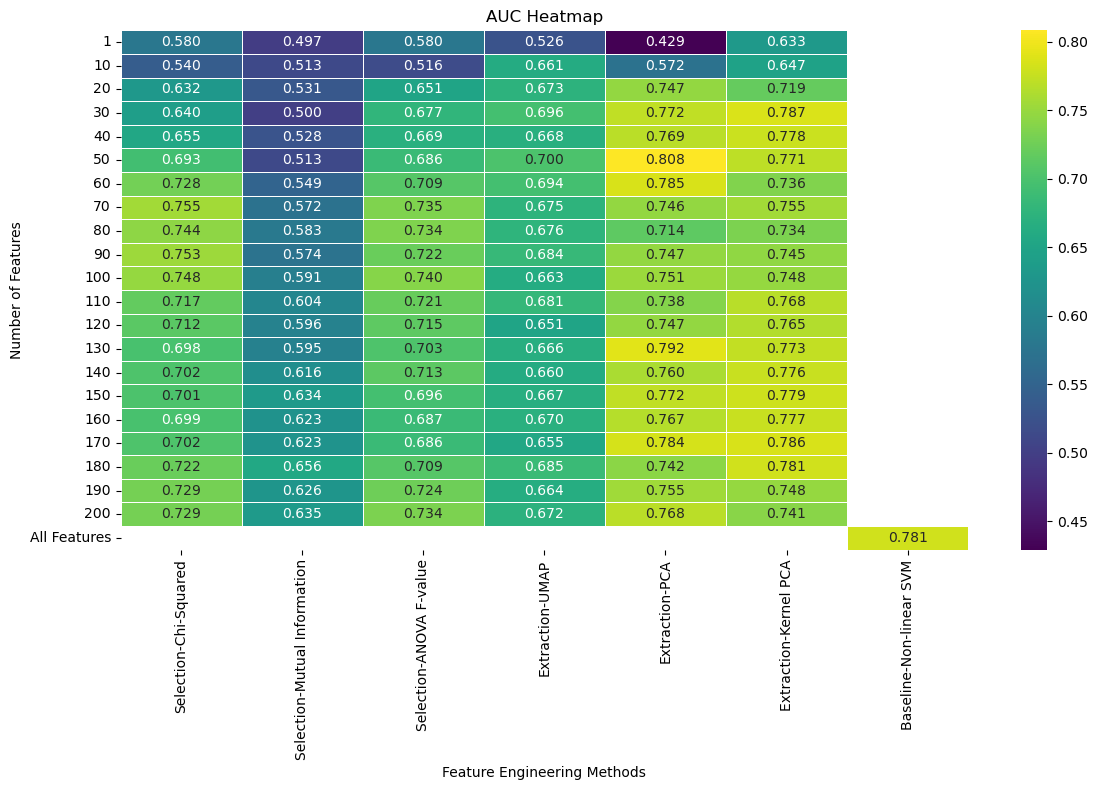

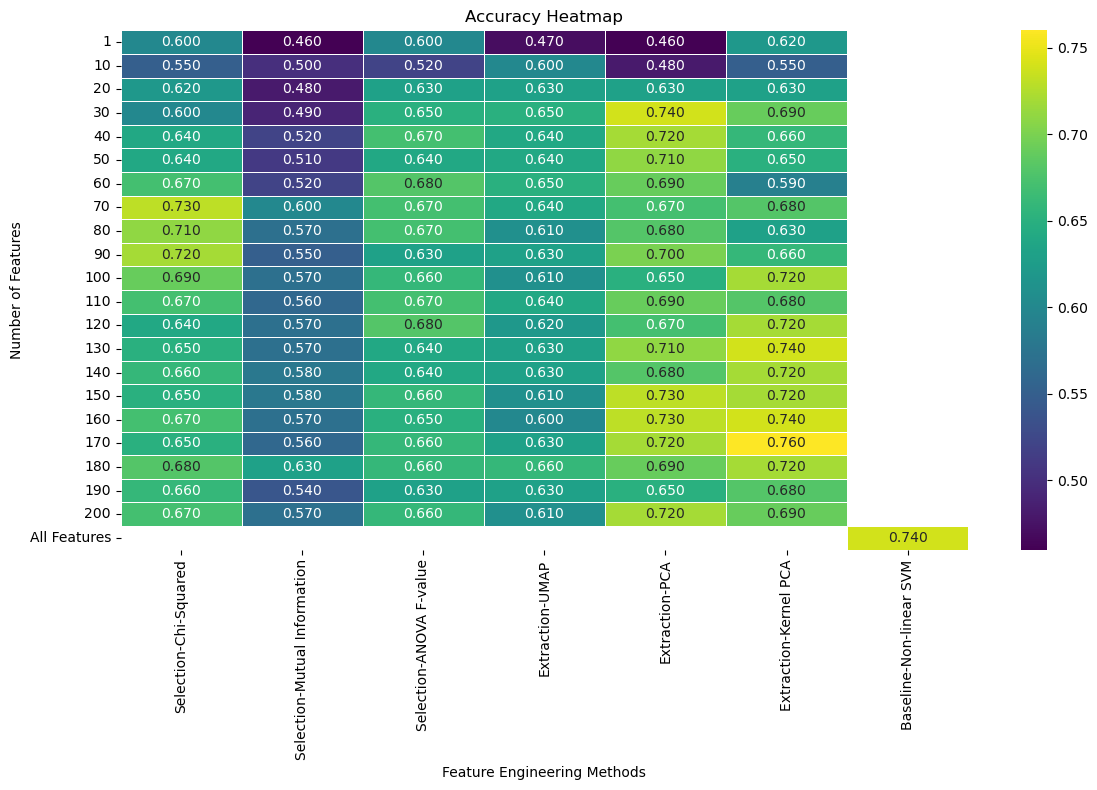

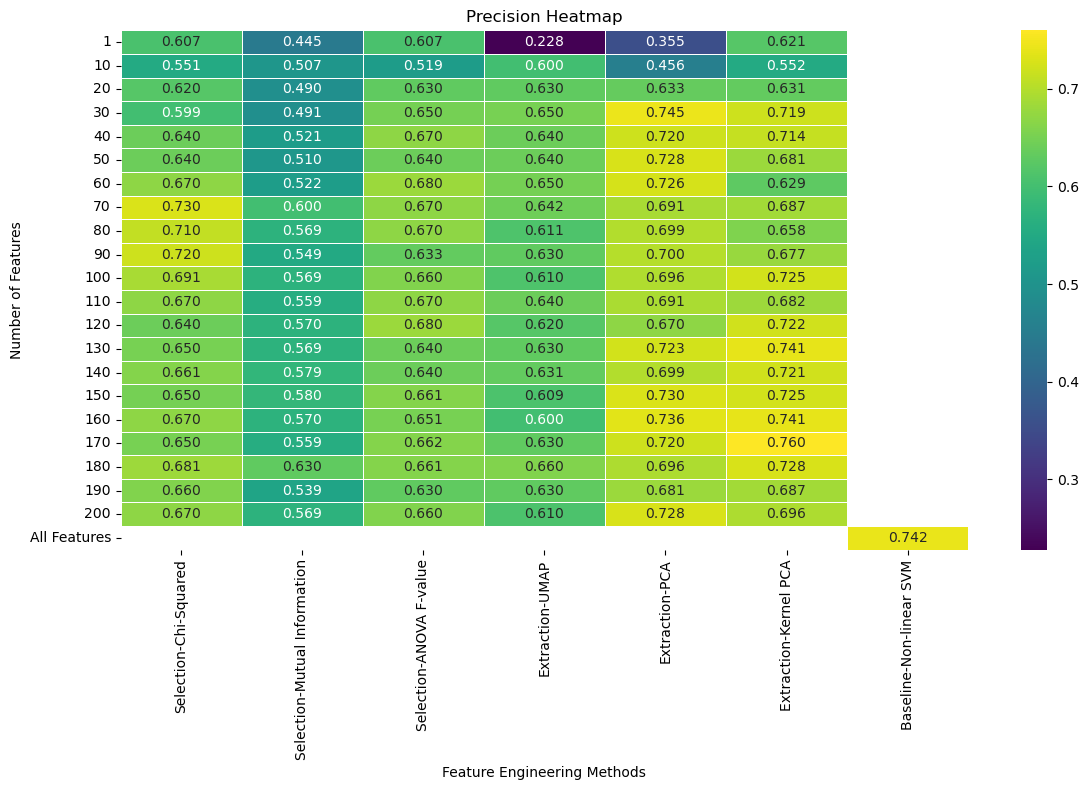

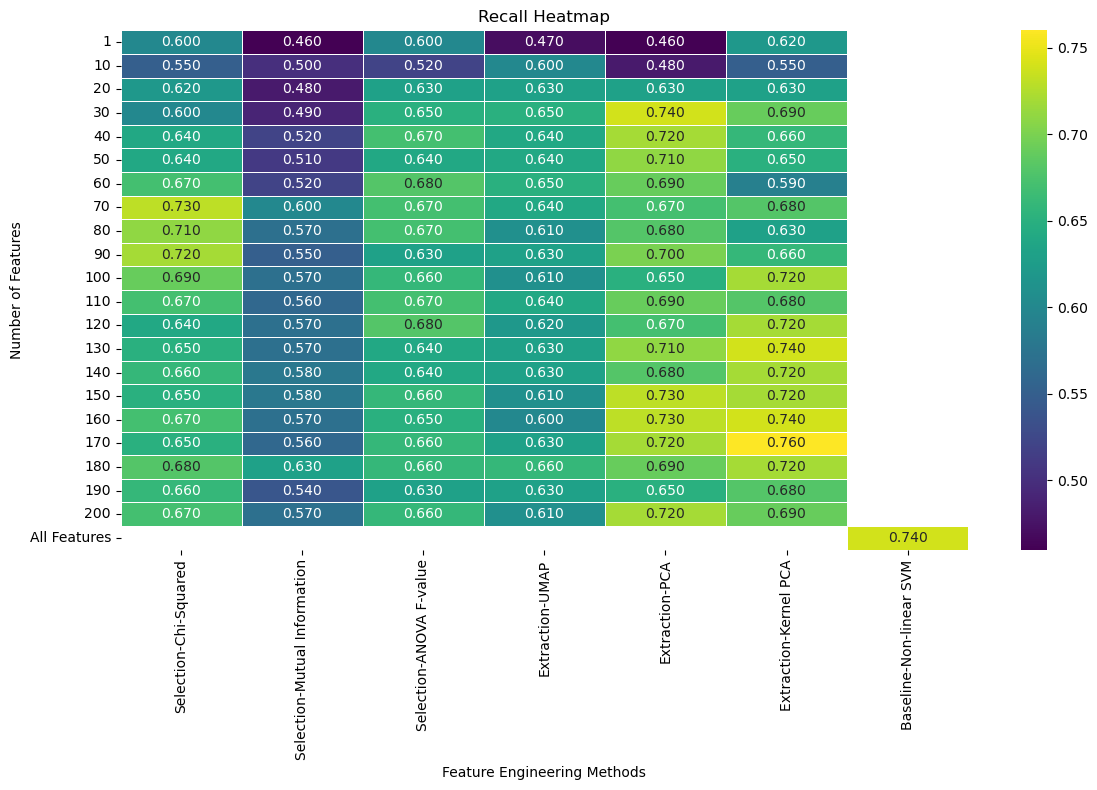

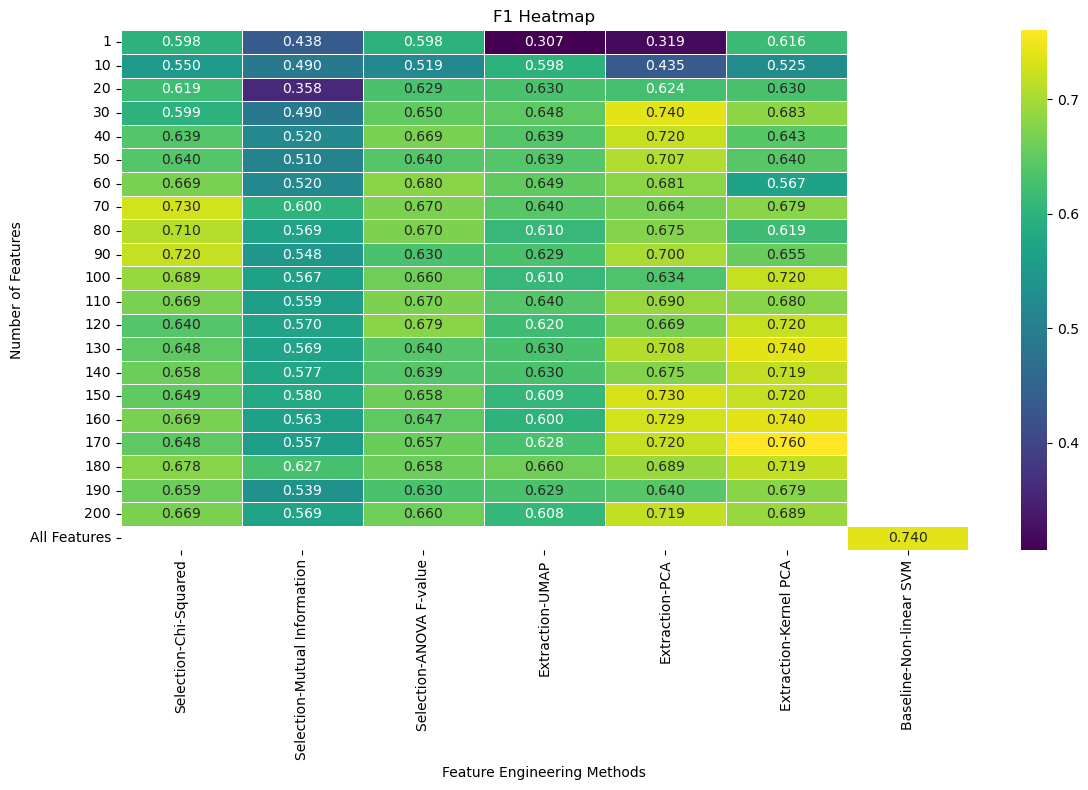

In [9]:
def plot_heatmap(df, metric, title):
    heatmap_data = df[metric].unstack(level=[1, 2])
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".3f", linewidths=0.5)

    plt.title(f"{title}")
    plt.xlabel("Feature Engineering Methods")
    plt.ylabel("Number of Features")
    plt.tight_layout()
    plt.show()

# heatmaps for each metric
for metric in metric_names:
    plot_heatmap(df_combined_results, metric, f"{metric} Heatmap")

### Line Charts

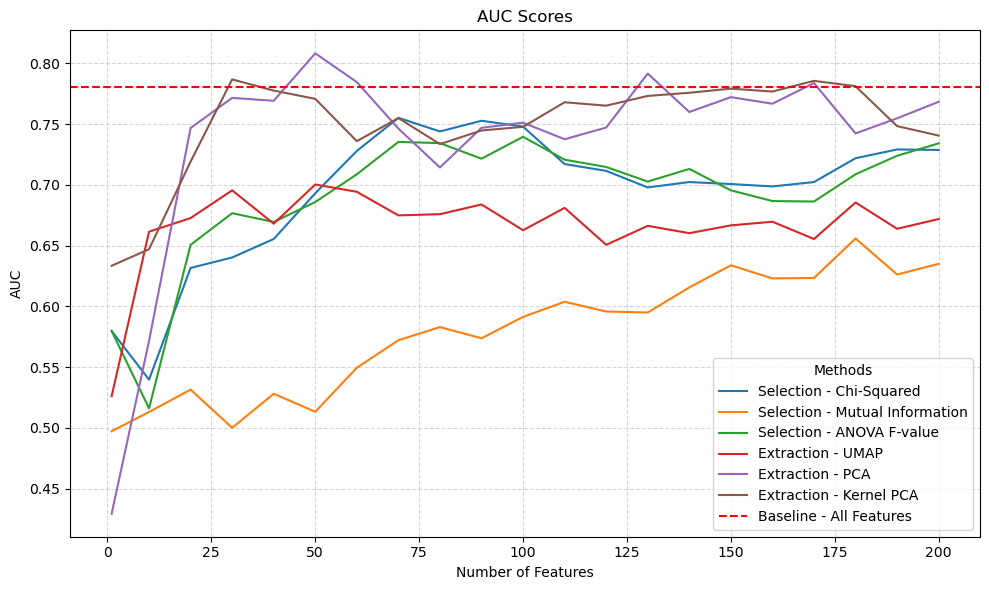

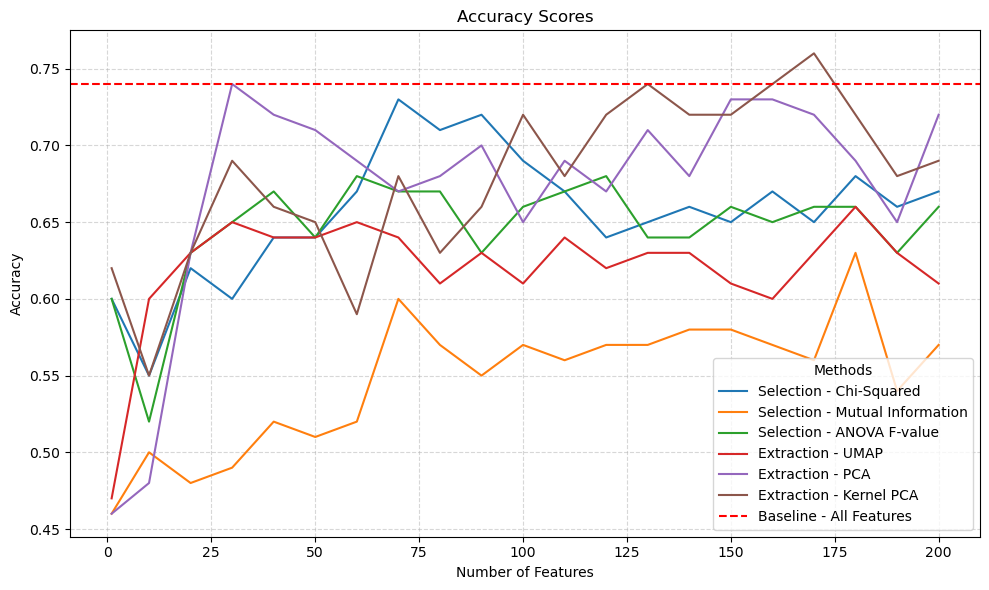

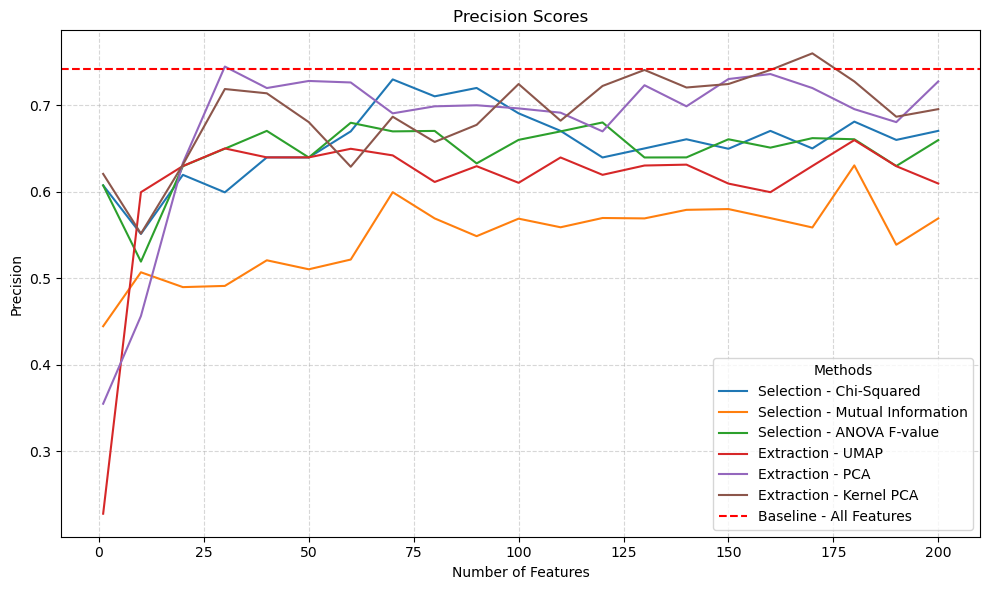

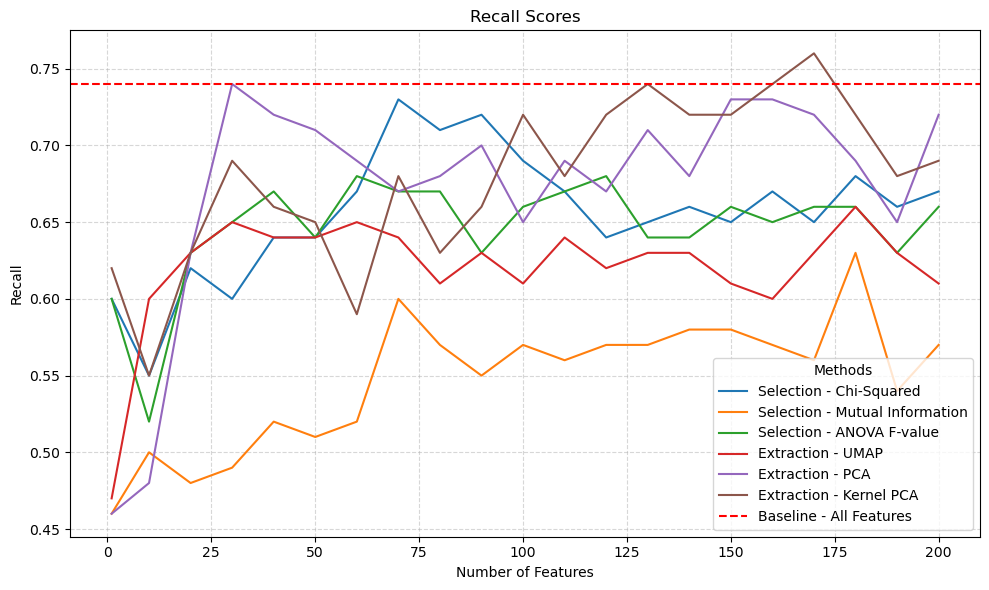

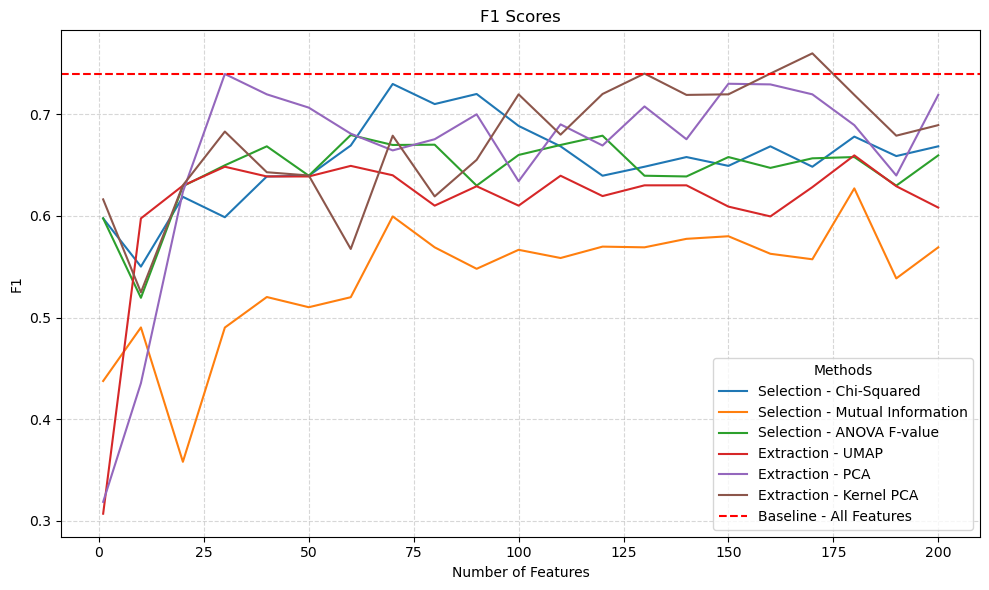

In [10]:
def plot_metric_progression(df, metric, title):
    plt.figure(figsize=(10, 6))

    # plotting feature eng. methods
    for method_type in ['Selection', 'Extraction']:
        for method in df.xs(method_type, level=1).index.get_level_values(1).unique():
            metric_values = df.xs((slice(None), method_type, method))[metric]
            feature_counts = df.xs((slice(None), method_type, method)).index.get_level_values(0)
            plt.plot(feature_counts, metric_values, label=f"{method_type} - {method}")

    # adding baseline model
    baseline_values = df.xs(("All Features", "Baseline", best_model_name))[metric]
    plt.axhline(y=baseline_values, color='red', linestyle='--', label='Baseline - All Features')

    plt.title(f"{metric} Scores")
    plt.xlabel('Number of Features')
    plt.ylabel(f'{metric}')
    plt.legend(title='Methods')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# plotting each metric
for metric in metric_names:
    plot_metric_progression(df_combined_results, metric, f"{metric} Scores")
